In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from ebm.probability import log_distributions, fit_distributions, predict_stage
from ebm.mcmc import greedy_ascent, mcmc, get_optimal_order

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data

folder = Path('/data01/bgutman/MRI_data/PPMI/EBM_data/')
data = pd.read_csv(folder / 'corrected_ENIGMA-PD_Mixed_Effects_train_test_split.csv', index_col=0)
df = pd.read_csv(folder / 'ENIGMA-PD-regional.csv') # to merge with data, to obtain patients' metadata

train, test = train_test_split(data, stratify=data['cohort'], test_size=0.1, random_state=777)
X_train = train.drop(['SubjID', 'Dx', 'Sex', 'Age', 'cohort'], axis=1).values
y_train = train['Dx'].values
X_test = test.drop(['SubjID', 'Dx', 'Sex', 'Age', 'cohort'], axis=1).values
y_test = test['Dx'].values

# Precompute train, test probability distributions P(x| E), P(x| not E)

train_log_p_e, train_log_p_not_e = log_distributions(X_train, y_train)
test_log_p_e, test_log_p_not_e = log_distributions(X_train, y_train, X_test=X_test, y_test=y_test)

In [3]:
# Load results from MCMC run

# No connectivity prior
all_orders = np.load('../logs/order_mcmc.npy')
order_map, best_order = get_optimal_order(all_orders)

# With connectivity prior
# all_orders_prior = np.load('../logs/prior_order_mcmc.npy')
# order_map_prior, best_order_prior = get_optimal_order(all_orders_prior)

In [4]:
best_order

array([43,  9,  6, 40, 61, 27, 23, 57, 29, 15, 22, 56, 36,  2, 60, 26, 25,
       20, 54, 63, 18, 16, 62, 28, 34, 13, 47, 41,  7, 59, 51, 52, 50, 44,
        0, 11, 32, 53,  3, 37, 45, 67, 49, 39, 66, 64, 17, 46, 12, 10, 30,
       33, 21, 55, 24, 42, 58,  8, 35,  4, 38, 31, 65, 48, 14,  1, 19,  5])

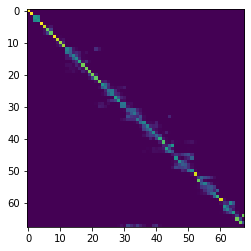

In [5]:
plt.imshow(order_map[best_order]);

In [6]:
# Given optimal events order and probability distr. p(x| E), p(x| not E) computes
# optimale stage for input subjects

probas = predict_stage(best_order, train_log_p_e, train_log_p_not_e).T
stage = np.argmax(probas, axis=1)
train['pred_stage'] = stage

probas = predict_stage(best_order, test_log_p_e, test_log_p_not_e).T
stage = np.argmax(probas, axis=1)
test['pred_stage'] = stage

/home/kurmukov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/kurmukov/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
train_stages = pd.merge(left=df[['SubjID', 'site', 'cohort', 'HY1234']], right=train, on='SubjID', how='right')
test_stages = pd.merge(left=df[['SubjID', 'site', 'cohort', 'HY1234']], right=test, on='SubjID', how='right')

In [8]:
train_stages.to_csv('/data01/bgutman/parkinson_ebm/train_parkinson_progression_stages.csv')
test_stages.to_csv('/data01/bgutman/parkinson_ebm/test_parkinson_progression_stages.csv')

# compute expected stage instead of MAP

In [9]:
def compute_expectation(log_probabilities):
    expected = 0
    for s, p in zip(np.arange(68), np.exp(log_probabilities)):
        expected+= s*p
    return expected/np.exp(log_probabilities).sum()

def compute_all_expectations(all_log_probabilities):
    expected = []
    for subject in all_log_probabilities:
        expected.append(compute_expectation(subject))
    return expected

# TODO: compute stats. signific. t-test